In [1]:
import pandas as pd
import numpy as np
from bokeh.plotting import figure
from bokeh.io import show, output_notebook, output_file
from bokeh.palettes import Category20_16
from bokeh.layouts import column, row, WidgetBox
from bokeh.models import Panel, ColumnDataSource, HoverTool
from bokeh.models.widgets import Tabs, CheckboxGroup, Slider, RangeSlider

# 设置为在笔记本中输出情节
output_notebook()
# output_file('/Users/tzhu/Downloads/hist1.html')

# 参考：http://liyangbit.com/pythonvisualization/Bokeh-Data-Visualization/
# 另一个：https://zhuanlan.zhihu.com/p/28334595
# 教程：https://github.com/DonaldDai/Bokeh-CN#PlottingwithBasicGlyphs

Loading BokehJS ...

* Plot: plots是bokeh的核心，是包含图形、导航、数据以及其他工具的容器。和matplotlib中的figure差不多吧，个人理解为画布。
* Glyphs: glyph我理解为图形标记，基本图形结构，也就是线条line等。
* Guides and Annotations: Guide就是导航按钮，如缩放、拖拽按钮等，Annotation就是一些标签、图例等。
* Ranges: 数据的展示范围，也就是坐标轴范围。p = figure(x_range=[0,10], y_range=(10, 20))
* Resoures: 主要是相关JS和CSS文件，默认会从cdn服务器上加载，这样的话展示可能需要联网才行。如果希望生成离线文件，设置output_file的model参数为inline（output_file(mode='inline')）。下面再来个散点图。

In [2]:
hpth='/Users/tzhu/work/opensource/Bokeh-Python-Visualization/application'
# 将 CSV 中的数据读入
flights = pd.read_csv(f'{hpth}/data/flights.csv', index_col=0)

# 兴趣栏的统计数据汇总
flights['arr_delay'].describe()

count    327346.000000
mean          6.895377
std          44.633292
min         -86.000000
25%         -17.000000
50%          -5.000000
75%          14.000000
max        1272.000000
Name: arr_delay, dtype: float64

In [26]:
# 创建带标签的空白图
def show_tmp_plot():
    tmpplot = figure(plot_width = 600, plot_height = 600, 
               title = 'Example Glyphs',
               x_axis_label = 'X', y_axis_label = 'Y')

    # 示例数据
    squares_x = [1, 3, 4, 5, 8]
    squares_y = [8, 7, 3, 1, 10]
    circles_x = [9, 12, 4, 3, 15]
    circles_y = [8, 4, 11, 6, 10]

    # 添加方形 glyph
    tmpplot.square(squares_x, squares_y, size = 12, color = 'navy', alpha = 0.6)
    # 添加圆形 glyph
    tmpplot.circle(circles_x, circles_y, size = 12, color = 'red')

    # 显示绘图
    show(tmpplot)

show_tmp_plot()

In [3]:
arr_hist, edges = np.histogram(flights['arr_delay'], bins = int(180/5), range = [-60, 120])

# 将信息放入 dataframe
delays = pd.DataFrame({'flights': arr_hist, 'left': edges[:-1], 'right': edges[1:]})

/Users/tzhu/.virtualenv/stock/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/tzhu/.virtualenv/stock/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


In [28]:
# 创建空白绘图
def show_simple_hist():
    p = figure(plot_height = 400, plot_width = 600, title = 'Histogram of Arrival Delays', x_axis_label = 'Delay (min)]', y_axis_label = 'Number of Flights')

    # 添加一个 quad glphy
    p.quad(bottom=0, top=delays['flights'], 
           left=delays['left'], right=delays['right'], 
           fill_color='red', line_color='black')

    # 显示绘图
    show(p)
    
show_simple_hist()

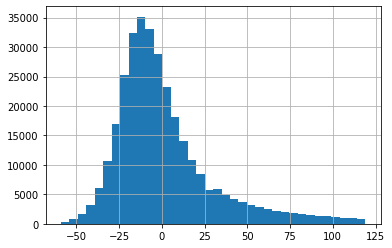

In [4]:
# 同样的图，用 pd 自带的 hist
flights[(flights.arr_delay > -60) & (flights.arr_delay < 120)].arr_delay.hist(bins=36)

In [5]:
def show_hover_hist():
    # 将 dataframe 转换为 列数据源
    src = ColumnDataSource(delays)
    print(src.data.keys())

    p1 = figure(plot_height = 400, plot_width = 600, title = 'Histogram of Arrival Delays', x_axis_label = 'Delay (min)]', y_axis_label = 'Number of Flights')
    p1.quad(source = src, bottom=0, top='flights',  left='left', right='right', fill_color='red', line_color='black')


    # hover
    h = HoverTool(tooltips = [('Delay Interval Left ', '@left'),
                              ('(x,y)', '($x, $y)')])

    # 绘图样式
    # p = style(p)

    # 将悬停工具添加到图中
    p1.add_tools(h)

    show(p1)

dict_keys(['index', 'flights', 'left', 'right'])


In [4]:
# 制作数据集的完整代码，该函数接收我们想要包括的航空公司列表，要绘制的最小和最大延迟，以及以分钟为单位的指定 bin 宽度。
def make_dataset(carrier_list, range_start = -60, range_end = 120, bin_width = 5):

    assert range_start < range_end, "Start must be less than end!"
    
    by_carrier = pd.DataFrame(columns=['proportion', 'left', 'right',
                                       'f_proportion', 'f_interval',
                                       'name', 'color'])
    range_extent = range_end - range_start
    # Iterate through all the carriers
    for i, carrier_name in enumerate(carrier_list):

        # Subset to the carrier
        subset = flights[flights['name'] == carrier_name]

        # Create a histogram with specified bins and range
        arr_hist, edges = np.histogram(subset['arr_delay'], bins = int(range_extent / bin_width), range = [range_start, range_end])

        # Divide the counts by the total to get a proportion and create df
        arr_df = pd.DataFrame({'proportion': arr_hist / np.sum(arr_hist), 'left': edges[:-1], 'right': edges[1:] })

        # Format the proportion
        arr_df['f_proportion'] = ['%0.5f' % proportion for proportion in arr_df['proportion']]

        # Format the interval
        arr_df['f_interval'] = ['%d to %d minutes' % (left, right) for left,
                                right in zip(arr_df['left'], arr_df['right'])]

        # Assign the carrier for labels
        arr_df['name'] = carrier_name

        # Color each carrier differently
        arr_df['color'] = Category20_16[i]

        # Add to the overall dataframe
        by_carrier = by_carrier.append(arr_df)

    # Overall dataframe
    by_carrier = by_carrier.sort_values(['name', 'left'])  
    # Convert dataframe to column data source
    return ColumnDataSource(by_carrier)

In [15]:
def make_plot(src):
    # Blank plot with correct labels
    p = figure(plot_width = 700, plot_height = 700,
              title = 'Histogram of Arrival Delays by Carrier',
              x_axis_label = 'Delay (min)', y_axis_label = 'Proportion')

    # Quad glyphs to create a histogram
    p.quad(source = src, bottom = 0, top = 'proportion', left = 'left', right = 'right',
           color = 'color', fill_alpha = 0.7, hover_fill_color = 'color', legend_field='name',
           hover_fill_alpha = 1.0, line_color = 'black')

    # Hover tool with vline mode
    hover = HoverTool(tooltips=[('Carrier', '@name'), ('Delay', '@f_interval'), ('Proportion', '@f_proportion')], mode='vline')

    p.add_tools(hover)

    # Styling
#         p = style(p)

    return p

In [16]:
available_carriers=flights['name'].unique()
x=make_dataset(available_carriers)
p=make_plot(x)
show(p)

In [18]:
# 制作复选的小部件后，需要将选定的航空公司复选框链接到图表上显示的信息。 
# 这是使用 CheckboxGroup 的 .on_change 方法和我们定义的 update 函数完成的。 
# update 函数总是有三个参数：attr ，old，new 并根据选择控件更新绘图。 
# 我们更改图表上显示的数据的方法是改变我们传递给 make_plot 函数中的 glyph(s) 的数据源。 
# 这可能听起来有点抽象，所以这里是有一个 update 函数的例子，它改变了直方图以显示所选的航空公司：
def update(attr, old, new):

    # Find the selected carriers
    carriers_to_plot = [carrier_selection.labels[i] for i in carrier_selection.active]

    # Change binwidth to selected value
    bin_width = binwidth_select.value

    # Value for the range slider is a tuple (start, end)
    range_start = range_select.value[0]
    range_end = range_select.value[1]

    # Create new ColumnDataSource
    new_src = make_dataset(carriers_to_plot,
                           range_start = range_start,
                           range_end = range_end,
                           bin_width = bin_width)

    # Update the data on the plot
    src.data.update(new_src.data)

In [20]:
# Create the checkbox selection element, available carriers is a  
# list of all airlines in the data
carrier_selection = CheckboxGroup(labels=available_carriers.tolist(), active = [0, 1])

# Select the airlines names from the selection values
[carrier_selection.labels[i] for i in carrier_selection.active]

carrier_selection.on_change('active', update)

# Slider to select the binwidth, value is selected number
binwidth_select = Slider(start = 1, end = 30,
                     step = 1, value = 5,
                     title = 'Delay Width (min)')
# Update the plot when the value is changed
binwidth_select.on_change('value', update)

# RangeSlider to change the maximum and minimum values on histogram
range_select = RangeSlider(start = -60, end = 180, value = (-60, 120),
                           step = 5, title = 'Delay Range (min)')

# Update the plot when the value is changed
range_select.on_change('value', update)

In [21]:
# Change plot title to match selection
bin_width = binwidth_select.value
p.title.text = 'Delays with %d Minute Bin Width' % bin_width

In [24]:
# Put controls in a single element
controls = WidgetBox(carrier_selection, binwidth_select, range_select)

# Create a row layout
layout = row(controls, p)

# Make a tab with the layout
tab = Panel(child=layout, title = 'Delay Histogram')
tabs = Tabs(tabs=[tab])

In [25]:
# 需要一个独立的 bokeh server 才能实现python callback 的交互。否则只能用 js callback 实现交互
show(layout)

You are generating standalone HTML/JS output, but trying to use real Python
callbacks (i.e. with on_change or on_event). This combination cannot work.

Only JavaScript callbacks may be used with standalone output. For more
information on JavaScript callbacks with Bokeh, see:

    https://docs.bokeh.org/en/latest/docs/user_guide/interaction/callbacks.html

Alternatively, to use real Python callbacks, a Bokeh server application may
be used. For more information on building and running Bokeh applications, see:

    https://docs.bokeh.org/en/latest/docs/user_guide/server.html



In [27]:
tuple(['admit', 'gre', 'gpa', 'rank'])

('admit', 'gre', 'gpa', 'rank')